# OLS on time-aware smoothed ratings

# Importing libraries and data

In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import scipy
import psycopg2
con = psycopg2.connect(database='codeforces', user='Joy')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['figure.facecolor'] = 'white'


/usr/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


this file still contains the Savitzky–Golay filter on ratings, but it has other information we need

drop the smooth rating columns and add the time aware ones

In [3]:
train = pd.read_csv('training_linear_regression_smooth.csv', engine='c')
train.dropna(inplace=True, axis=0)

#df_smooth = pd.read_csv('user_ratings_smoothed.csv', engine='c')
df_smooth = pd.read_csv('user_ratings_smoothed_atleast5contests.csv', engine='c')

##  Filter out users who have done fewer than $x$ competitions

```
min_contests = 5
g = df_smooth.groupby('handle')
list_smooth = []
for k, v in g:
    if v.shape[0] >= min_contests:
        list_smooth.append(v)

len(list_smooth)

df_Smooth_atleast5 = pd.concat(list_smooth)

print df_smooth.shape
print df_Smooth_atleast5.shape
df_Smooth_atleast5.to_csv('user_ratings_smoothed_atleast5contests.csv', index=False, header=True)
```

## Calculate deltas (this is already saved in the file)
```
# calculate difference
gusr = smoothed_ratings.groupby('handle')
stack = []

for usr, dfu in gusr:
    dfu.is_copy=False
    dfu.sort_values('ratingupdatetimeseconds', inplace=True)
    stack.append(dfu)

df_smooth = pd.concat(stack)
for month in range(1, 6):
    curr = df_smooth["smoothed_%dmonths" % month]
    prev = np.roll(curr, 1)

    delta = curr - prev
    df_smooth["delta_smoothed_%dmonths" % month] = delta
```

In [4]:
dfm = pd.merge(train, df_smooth, on=['handle', 'contestid'])
print dfm.shape
dfm.head()

(627996, 71)


,*special,2-sat,binary search,bitmasks,brute force,chinese remainder theorem,combinatorics,constructive algorithms,contestid,contesttime,...,smoothed_1months,smoothed_2months,smoothed_3months,smoothed_4months,smoothed_5months,delta_smoothed_1months,delta_smoothed_2months,delta_smoothed_3months,delta_smoothed_4months,delta_smoothed_5months
0,0,0,0,1,0,0,0,1,10,1271346469,...,1821.000000,1748.00,1748.000000,1748.000000,1748.000000,57.000000,65.00,65.000000,65.000000,65.000000
1,0,0,0,0,1,0,0,0,101,1312391097,...,2609.500000,2624.25,2596.000000,2570.909091,2564.250000,-18.500000,4.65,13.500000,3.809091,21.557692
2,0,0,0,0,1,0,0,0,105,1313248099,...,2607.666667,2617.25,2615.857143,2587.300000,2573.666667,-1.833333,-7.00,19.857143,16.390909,9.416667
3,0,0,0,0,0,0,0,0,107,1314112086,...,2608.666667,2609.00,2619.000000,2598.500000,2576.692308,1.000000,-8.25,3.142857,11.200000,3.025641
4,0,0,0,0,0,0,0,0,109,1314633737,...,2606.750000,2607.40,2616.428571,2598.727273,2578.428571,-1.916667,-1.60,-2.571429,0.227273,1.736264


In [5]:
dfm.columns

Index([u'*special', u'2-sat', u'binary search', u'bitmasks', u'brute force',
       u'chinese remainder theorem', u'combinatorics',
       u'constructive algorithms', u'contestid', u'contesttime',
       u'data structures', u'dfs and similar', u'divide and conquer', u'dp',
       u'dsu', u'expression parsing', u'fft', u'flows', u'games', u'geometry',
       u'graph matchings', u'graphs', u'greedy', u'hashing', u'implementation',
       u'math', u'matrices', u'meet-in-the-middle', u'n_contest', u'n_harder',
       u'n_harder100', u'n_harder50', u'n_harder500', u'n_wrong_mean',
       u'n_wrong_std', u'number theory', u'probabilities', u'problems_solved',
       u'rating_change', u'rating_change_smooth', u'rating_diff_mean',
       u'rating_diff_std', u'schedules', u'shortest paths', u'sortings',
       u'string suffix structures', u'strings', u'ternary search',
       u'time_between_mean', u'time_between_std', u'trees', u'two pointers',
       u'user_rating', u'user_rating_smooth', u'ha

In [20]:
X = dfm.drop(['contesttime', 'contestid', 'handle'], axis=1)
X.reset_index()

month = 3
Y = X['delta_smoothed_%dmonths'%month]
for i in range(1, 6):
    X.drop('delta_smoothed_%dmonths' % i, axis = 1, inplace=True)
    
X['bias'] = 1

# Null model

In [103]:
# null model

ss_tot = np.var(Y) * len(Y)

ybar = np.mean(Y)
ss_tot = np.sum((Y-ybar)**2)
ss_res = np.sum((Y - 0)**2)

1 - ss_res / ss_tot

-0.053723831804432631

In [104]:
# fit a horizontal line
results = sm.OLS(Y, [1]*len(Y)).fit()
print results.summary()

                              OLS Regression Results                              
Dep. Variable:     delta_smoothed_3months   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                  0.000
Method:                     Least Squares   F-statistic:                       inf
Date:                    Wed, 07 Jun 2017   Prob (F-statistic):                nan
Time:                            13:57:20   Log-Likelihood:            -2.2365e+06
No. Observations:                  465028   AIC:                         4.473e+06
Df Residuals:                      465027   BIC:                         4.473e+06
Df Model:                               0                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

/usr/local/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1396: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


# First order model

In [182]:
X.columns

Index([u'*special', u'2-sat', u'binary search', u'bitmasks', u'brute force',
       u'chinese remainder theorem', u'combinatorics',
       u'constructive algorithms', u'data structures', u'dfs and similar',
       u'divide and conquer', u'dp', u'dsu', u'expression parsing', u'fft',
       u'flows', u'games', u'geometry', u'graph matchings', u'graphs',
       u'greedy', u'hashing', u'implementation', u'math', u'matrices',
       u'meet-in-the-middle', u'n_contest', u'n_harder', u'n_harder100',
       u'n_harder50', u'n_harder500', u'n_wrong_mean', u'n_wrong_std',
       u'number theory', u'probabilities', u'problems_solved',
       u'rating_change', u'rating_change_smooth', u'rating_diff_mean',
       u'rating_diff_std', u'schedules', u'shortest paths', u'sortings',
       u'string suffix structures', u'strings', u'ternary search',
       u'time_between_mean', u'time_between_std', u'trees', u'two pointers',
       u'user_rating', u'user_rating_smooth', u'time', u'contestname',
       u'

In [22]:
cols = ['rating_diff_mean', 'n_harder', 'n_wrong_mean', 'rating_diff_std', 'n_contest', 'smoothed_%dmonths'%month]

results_rating_only = sm.OLS(Y.values, X['smoothed_%dmonths'%month]).fit()
print "ratings only:", results_rating_only.rsquared

results = sm.OLS(Y.values, X[cols]).fit()
print "all params  :", results.rsquared
#
##print X[cols].head(), Y.head()

ratings only: 0.0409767032093
all params  : 0.109562081002


## throw out user's first 5 contests
This actually decreases accuracy for every bin

```
g = dfm.groupby('handle')
dfmlist = []
for k, v in g:
    v.is_copy = False
    v.sort_values('ratingupdatetimeseconds', inplace=True)
    v.reset_index(inplace=True)
    if v.shape[0] > 5:
        dfmlist.append(v.loc[5:])

dfm2 = pd.concat(dfmlist)

print dfm2.shape
print dfm.shape

dfm2.to_csv('training_linear_regression_smooth_filtered.csv', index=False, header=True)
dfm = pd.read_csv('training_linear_regression_smooth_filtered.csv', engine='c')
```

In [62]:
q, qbins = pd.qcut(dfm.user_rating_smooth, 20, retbins=True)
dfm['q'] = q

In [63]:
contr_all = []
contr_rating = []
contr_norating = []

colname = 'smoothed_%dmonths' % month

drop_users = set(['Hedgehogy', 'errorerror', 'Mhammad1', 'NelsonMondialu'])
for k, X in dfm.groupby('q'):
    print k, X.shape
    X.is_copy = False
    X.drop(['contesttime', 'contestid'], axis=1, inplace=True)
    
    # drop users who are tanking on purpose
    X.drop(X.index[X.handle.apply(lambda x: x in drop_users)], inplace=True)

    # select features to use
    Y = X['delta_smoothed_%dmonths' % month]
    X = X[cols]

    results_rating_only = sm.OLS(Y.values, X[colname]).fit()
    results = sm.OLS(Y.values, X).fit()
    X.drop(colname, inplace=True, axis=1)
    results_norating = sm.OLS(Y.values, X).fit()
    
    contr_all.append(results.rsquared)
    contr_rating.append(results_rating_only.rsquared)
    contr_norating.append(results_norating.rsquared)

    print k, "%6d entries, ---------------> %f, %f" %(X.shape[0], results.rsquared, results_rating_only.rsquared)
    #print results.summary()


(5.606, 1122.429] (31405, 72)


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(5.606, 1122.429]  31379 entries, ---------------> 0.269170, 0.217437
(1122.429, 1205.0] (31446, 72)
(1122.429, 1205.0]  31443 entries, ---------------> 0.256539, 0.189143
(1205.0, 1257.8] (31356, 72)
(1205.0, 1257.8]  31355 entries, ---------------> 0.221580, 0.152272
(1257.8, 1299.98] (31393, 72)
(1257.8, 1299.98]  31392 entries, ---------------> 0.192237, 0.117676
(1299.98, 1335.0] (31483, 72)
(1299.98, 1335.0]  31482 entries, ---------------> 0.169078, 0.087018
(1335.0, 1368.2] (31324, 72)
(1335.0, 1368.2]  31324 entries, ---------------> 0.085618, 0.034693
(1368.2, 1401.292] (31392, 72)
(1368.2, 1401.292]  31391 entries, ---------------> 0.017556, 0.002634
(1401.292, 1433.462] (31400, 72)
(1401.292, 1433.462]  31397 entries, ---------------> 0.008409, 0.004838
(1433.462, 1465.612] (31399, 72)
(1433.462, 1465.612]  31387 entries, ---------------> 0.028554, 0.026306
(1465.612, 1497.444] (31410, 72)
(1465.612, 1497.444]  31396 entries, ---------------> 0.049667, 0.046599
(1497.444, 1

(0, 0.3)

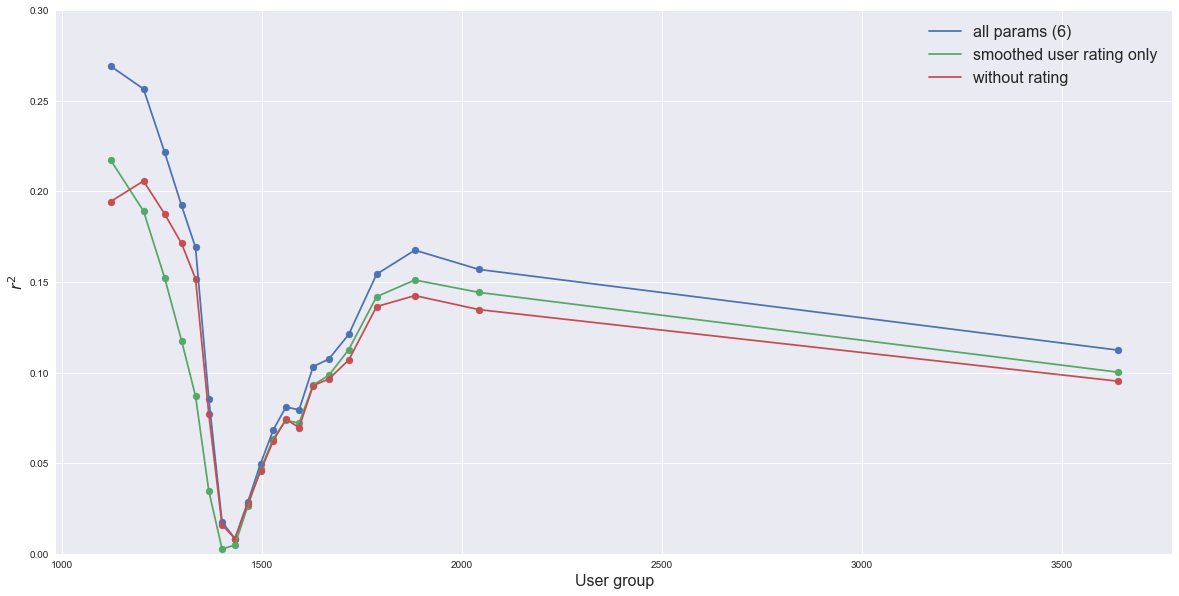

In [64]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

plt.plot   (qbins[1:], contr_all)
plt.scatter(qbins[1:], contr_all)
plt.plot   (qbins[1:], contr_rating)
plt.scatter(qbins[1:], contr_rating)
plt.plot   (qbins[1:], contr_norating)
plt.scatter(qbins[1:], contr_norating)

plt.ylabel('$r^2$', fontsize=16)
plt.xlabel('User group', fontsize=16)
plt.legend(['all params (6)', 'smoothed user rating only', 'without rating'], fontsize=16)
plt.ylim(0, .3)

(0, 0.2)

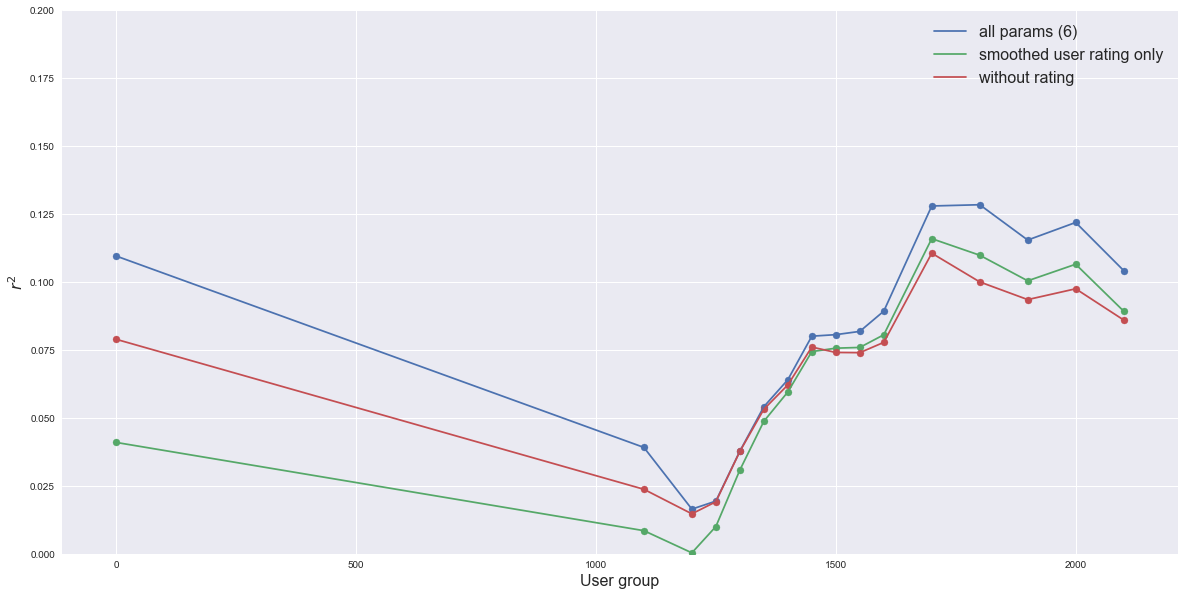

In [26]:
# Throwing out the first give contests for each user makes overall r2 much less
#plt.rcParams['figure.figsize'] = (20.0, 10.0)
#
#plt.plot   (lows, contr_all)
#plt.scatter(lows, contr_all)
#plt.plot   (lows, contr_rating)
#plt.scatter(lows, contr_rating)
#plt.plot   (lows, contr_norating)
#plt.scatter(lows, contr_norating)
#
#plt.ylabel('$r^2$', fontsize=16)
#plt.xlabel('User group', fontsize=16)
#plt.legend(['all params (6)', 'smoothed user rating only', 'without rating'], fontsize=16)
#plt.ylim(0, .2)

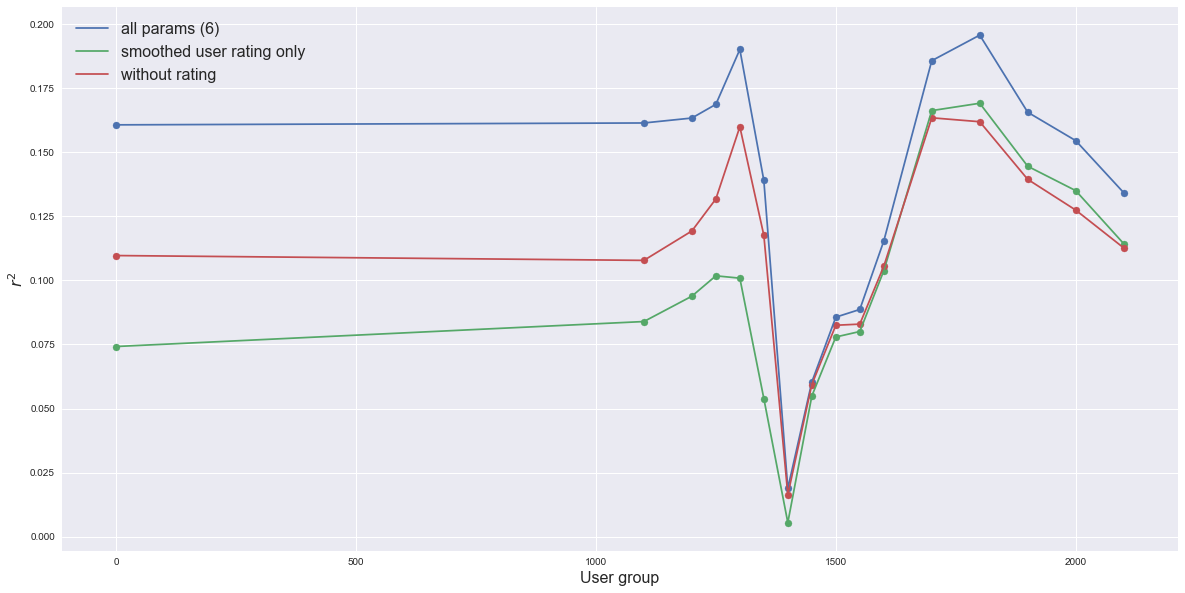

In [202]:
# --------------------- without throwing out the users with fewer than 5 contest
#plt.rcParams['figure.figsize'] = (20.0, 10.0)
#
#plt.plot   (lows, contr_all)
#plt.scatter(lows, contr_all)
#plt.plot   (lows, contr_rating)
#plt.scatter(lows, contr_rating)
#plt.plot   (lows, contr_norating)
#plt.scatter(lows, contr_norating)
#
#plt.ylabel('$r^2$', fontsize=16)
#plt.xlabel('User group', fontsize=16)
#plt.legend(['all params (6)', 'smoothed user rating only', 'without rating'], fontsize=16)

# Look ahead bias / Momentum
Note that there *will* be some leakage regardless of which algorithm we use, since that is smoothing by definition.

Here the future smoothed rating is modulated by the past ratings, thus creating a sort of "momentum".

For now, I don't think we can do much better than this

In [8]:
q, qbins = pd.qcut(dfm.user_rating_smooth, 20, retbins=True)
dfm['q'] = q
month=3

In [9]:
dfm['prev'] = np.roll(dfm['delta_smoothed_%dmonths' % month], 1)
Y = dfm['delta_smoothed_%dmonths'%month]

In [12]:
from copy import deepcopy
contr_all = []
contr_rating = []
contr_norating = []
contr_lookbehind = []
results_all = []

cols = ['rating_diff_mean', 'n_harder', 'n_wrong_mean', 'rating_diff_std', 'n_contest', 'smoothed_%dmonths'%month, 'prev']
colname = 'smoothed_%dmonths' % month

drop_users = set(['Hedgehogy', 'errorerror', 'Mhammad1', 'NelsonMondialu'])
for k, X in dfm.groupby('q'):
    print k, X.shape
    X.is_copy = False
    X.drop(['contesttime', 'contestid'], axis=1, inplace=True)
    
    # drop users who are tanking on purpose
    X.drop(X.index[X.handle.apply(lambda x: x in drop_users)], inplace=True)

    # select features to use
    Y = X['delta_smoothed_%dmonths' % month]
    
    #results_lookbehind = sm.OLS(Y.values, X['prev']).fit()
    X = X[cols]

    #results_rating_only = sm.OLS(Y.values, X[colname]).fit()
    results = sm.OLS(Y.values, X).fit()
    #X.drop(colname, inplace=True, axis=1)
    #results_norating = sm.OLS(Y.values, X).fit()
    #
    #contr_all.append(results.rsquared)
    #contr_rating.append(results_rating_only.rsquared)
    #contr_norating.append(results_norating.rsquared)
    #contr_lookbehind.append(results_lookbehind.rsquared)
    
    results_all.append(results)

    #print k, "%6d entries, ---------------> %f, %f" %(X.shape[0], results.rsquared, results_rating_only.rsquared)
    print k, "%6d entries, ---------------> %f" %(X.shape[0], results.rsquared)

 (5.606, 1122.429] (31405, 73)
(5.606, 1122.429]  31379 entries, ---------------> 0.320057
(1122.429, 1205.0] (31446, 73)
(1122.429, 1205.0]  31443 entries, ---------------> 0.326759
(1205.0, 1257.8] (31356, 73)
(1205.0, 1257.8]  31355 entries, ---------------> 0.288377
(1257.8, 1299.98] (31393, 73)
(1257.8, 1299.98]  31392 entries, ---------------> 0.248064
(1299.98, 1335.0] (31483, 73)
(1299.98, 1335.0]  31482 entries, ---------------> 0.207253
(1335.0, 1368.2] (31324, 73)
(1335.0, 1368.2]  31324 entries, ---------------> 0.113901
(1368.2, 1401.292] (31392, 73)
(1368.2, 1401.292]  31391 entries, ---------------> 0.040990
(1401.292, 1433.462] (31400, 73)
(1401.292, 1433.462]  31397 entries, ---------------> 0.029103
(1433.462, 1465.612] (31399, 73)
(1433.462, 1465.612]  31387 entries, ---------------> 0.054083
(1465.612, 1497.444] (31410, 73)
(1465.612, 1497.444]  31396 entries, ---------------> 0.066087
(1497.444, 1529.457] (31390, 73)
(1497.444, 1529.457]  31380 entries, -----------

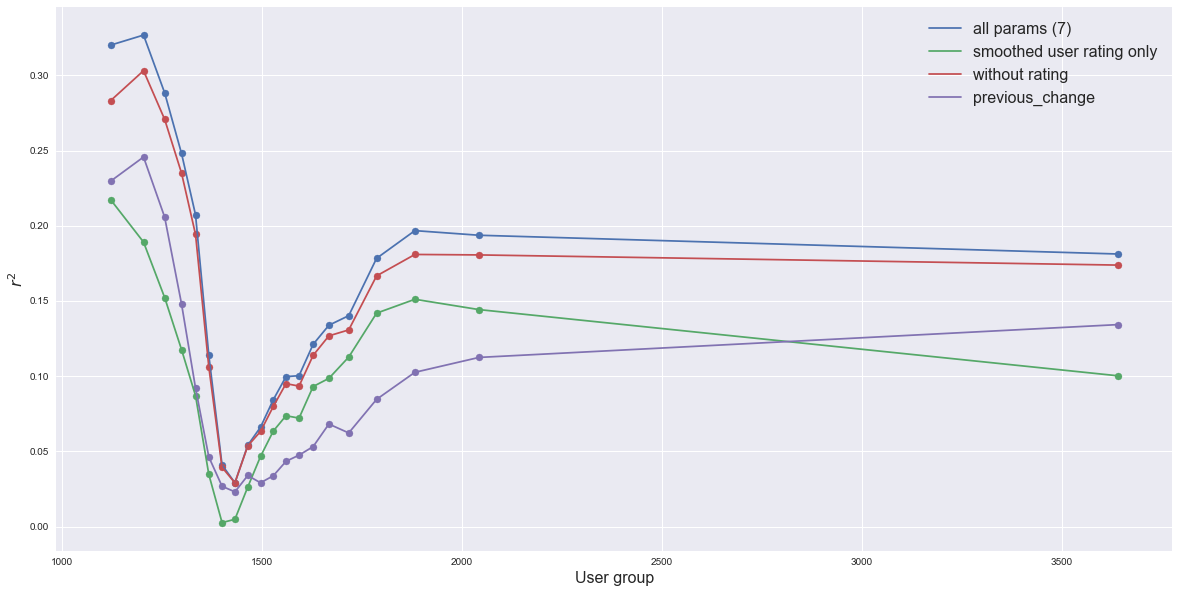

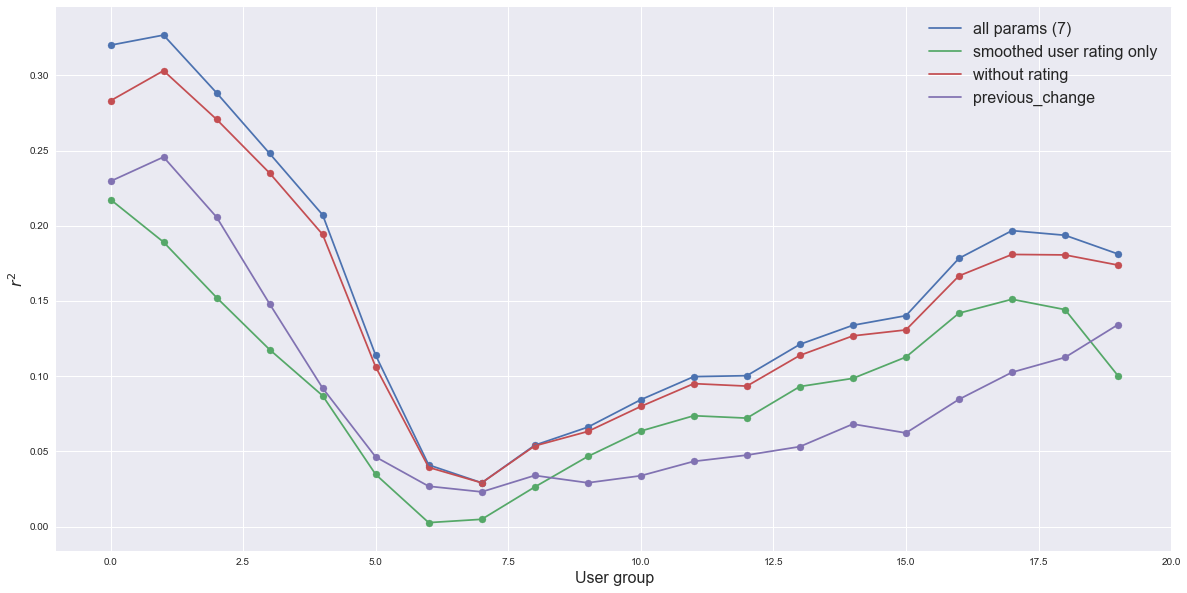

In [100]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

plt.plot   (qbins[1:], contr_all)
plt.scatter(qbins[1:], contr_all)
plt.plot   (qbins[1:], contr_rating)
plt.scatter(qbins[1:], contr_rating)
plt.plot   (qbins[1:], contr_norating)
plt.scatter(qbins[1:], contr_norating)
plt.plot   (qbins[1:], contr_lookbehind)
plt.scatter(qbins[1:], contr_lookbehind)

plt.ylabel('$r^2$', fontsize=16)
plt.xlabel('User group', fontsize=16)
plt.legend(['all params (7)', 'smoothed user rating only', 'without rating', 'previous_change'], fontsize=16)

plt.figure()
plt.plot   (range(20), contr_all)
plt.scatter(range(20), contr_all)
plt.plot   (range(20), contr_rating)
plt.scatter(range(20), contr_rating)
plt.plot   (range(20), contr_norating)
plt.scatter(range(20), contr_norating)
plt.plot   (range(20), contr_lookbehind)
plt.scatter(range(20), contr_lookbehind)

plt.ylabel('$r^2$', fontsize=16)
plt.xlabel('User group', fontsize=16)
plt.legend(['all params (7)', 'smoothed user rating only', 'without rating', 'previous_change'], fontsize=16)


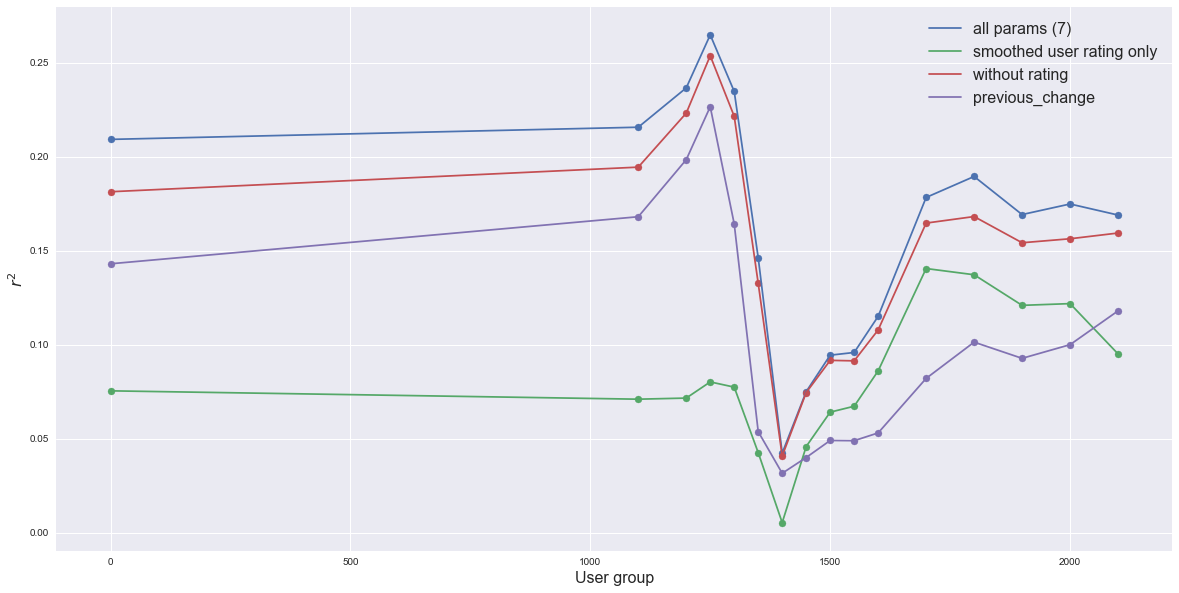

In [232]:
#plt.rcParams['figure.figsize'] = (20.0, 10.0)
#
#plt.plot   (lows, contr_all)
#plt.scatter(lows, contr_all)
#plt.plot   (lows, contr_rating)
#plt.scatter(lows, contr_rating)
#plt.plot   (lows, contr_norating)
#plt.scatter(lows, contr_norating)
#plt.plot   (lows, contr_lookbehind)
#plt.scatter(lows, contr_lookbehind)
#
#plt.ylabel('$r^2$', fontsize=16)
#plt.xlabel('User group', fontsize=16)
#plt.legend(['all params (7)', 'smoothed user rating only', 'without rating', 'previous_change'], fontsize=16)

In [80]:
test = sm.OLS(Y, dfm['prev']).fit()
print test.summary()

                              OLS Regression Results                              
Dep. Variable:     delta_smoothed_3months   R-squared:                       0.091
Model:                                OLS   Adj. R-squared:                  0.091
Method:                     Least Squares   F-statistic:                 6.303e+04
Date:                    Thu, 08 Jun 2017   Prob (F-statistic):               0.00
Time:                            14:31:11   Log-Likelihood:            -3.0163e+06
No. Observations:                  627996   AIC:                         6.033e+06
Df Residuals:                      627995   BIC:                         6.033e+06
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
prev        

In [78]:
test = sm.OLS(Y, dfm[cols + ['prev']]).fit()
print test.summary()

                              OLS Regression Results                              
Dep. Variable:     delta_smoothed_3months   R-squared:                       0.106
Model:                                OLS   Adj. R-squared:                  0.106
Method:                     Least Squares   F-statistic:                 1.059e+04
Date:                    Thu, 08 Jun 2017   Prob (F-statistic):               0.00
Time:                            13:00:04   Log-Likelihood:            -3.0113e+06
No. Observations:                  627996   AIC:                         6.023e+06
Df Residuals:                      627989   BIC:                         6.023e+06
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


In [82]:
dfm.loc[0]

*special                                             0
2-sat                                                0
binary search                                        0
bitmasks                                             1
brute force                                          0
chinese remainder theorem                            0
combinatorics                                        0
constructive algorithms                              1
contestid                                           10
contesttime                                 1271346469
data structures                                      1
dfs and similar                                      0
divide and conquer                                   0
dp                                                   2
dsu                                                  0
expression parsing                                   0
fft                                                  0
flows                                                0
games     

# Save the last entry for each user to use for UI

In [208]:
g = dfm.groupby('handle')
last_training_example = []
for k, v in g:
    v.is_copy = False
    v.sort_values('ratingupdatetimeseconds', inplace=True)
    v['handle'] = k
    
    rating = v.smoothed_3months.values[0]
    idx = np.where(qbins > rating)
    v['bin'] = qbins[idx[0][0]]
    
    last_training_example.append(v.loc[v.index[-1], cols+['bin', 'handle']])

In [218]:
last_training = pd.concat(last_training_example, axis=1)
last_training = last_training.transpose()

In [224]:
last_training.head()

,rating_diff_mean,n_harder,n_wrong_mean,rating_diff_std,n_contest,smoothed_3months,prev,bin,handle
401522,-107,1,0.4,280.914,4,1209.5,5.56667,1299.98,-----
65705,-1103.45,0,2.5,126.625,0,2068,4.26667,1529.46,---Grigor---
492003,-74.2619,7,1.47619,361.366,20,1435.67,-4.33333,1465.61,---JamesBond---
365295,4.5,12,1.75,397.05,5,1535,27,1401.29,--1
283455,-164.657,4,1.05882,374.395,7,1642.75,1.14286,1529.46,--ARYA--


In [226]:
from sqlalchemy import *
dbname = 'codeforces'
username = 'Joy'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
metadata = MetaData()
contests = Table('train_ols_last', metadata,
    Column('rating_diff_mean', Float),
    Column('n_harder', Float),
    Column('n_wrong_mean', Float),
    Column('rating_diff_std', Float),
    Column('n_contest', Integer),
    Column('smoothed_3months', Float),
    Column('prev', Float),
    Column('bin', Float),
    Column('handle', String, primary_key=True)
)
last_training.to_sql('train_ols_last', engine, if_exists='replace', index=False)

In [220]:
last_training.to_csv('webapp/training_linear_regression_last.csv', header=True, index=False)

# Plotting coefficients and saving models

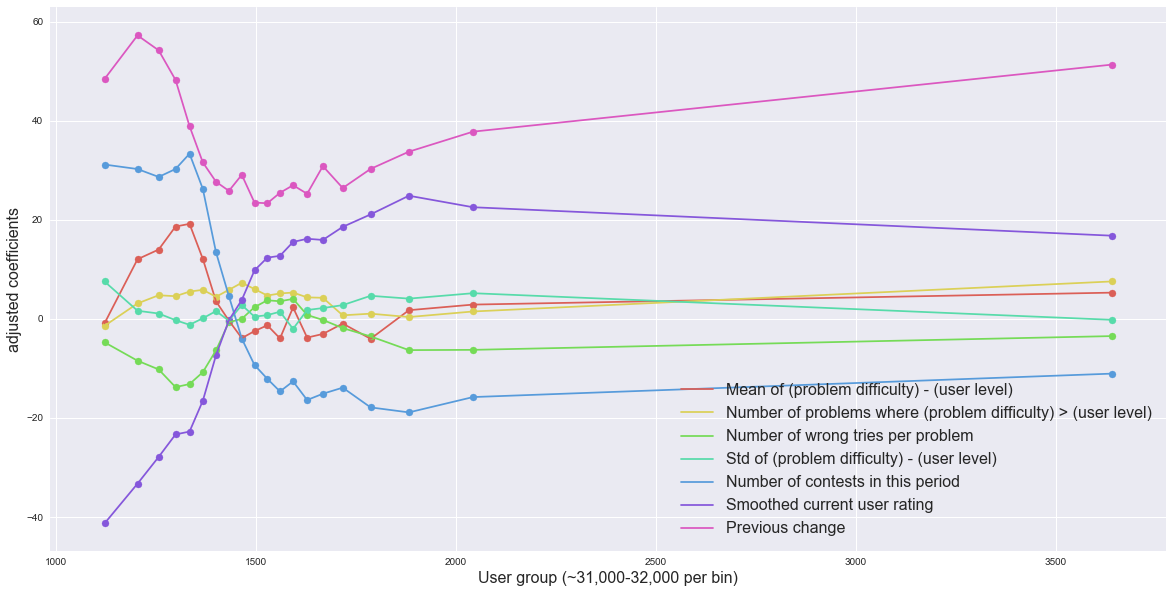

In [283]:
colors = sns.color_palette("hls", 7)
for i in range(7):
    plt.plot(qbins[1:], [r.tvalues[i] for r in results_all], c=colors[i])
    plt.scatter(qbins[1:], [r.tvalues[i] for r in results_all], c=colors[i])
    
plt.legend([
'Mean of (problem difficulty) - (user level)',
'Number of problems where (problem difficulty) > (user level)',
'Number of wrong tries per problem',
'Std of (problem difficulty) - (user level)',
'Number of contests in this period',
'Smoothed current user rating',
'Previous change'
], fontsize=16)

plt.xlabel("User group (~31,000-32,000 per bin)", fontsize=16)
plt.ylabel("adjusted coefficients", fontsize=16)

In [238]:
for i, res in enumerate(results_all):
    res.save('webapp/models/ols%d.pickle'% i)

In [244]:
with open('webapp/models/qbins.txt', 'w') as f:
    f.write(",".join(map(str, qbins)))

In [248]:
for q in qbins:
    print round(q)

6.0
1122.0
1205.0
1258.0
1300.0
1335.0
1368.0
1401.0
1433.0
1466.0
1497.0
1529.0
1561.0
1594.0
1629.0
1668.0
1718.0
1788.0
1883.0
2044.0
3641.0


In [260]:
res = sm.load('webapp/models/ols2.pickle')

In [254]:
last_training.reset_index(inplace=True)

In [258]:
x = last_training.loc[0, cols]

In [263]:
res.predict(x)

-8.4444467862281414

In [266]:
res = res.get_prediction(x)

In [272]:
print res.predicted_mean

[-8.4444467862281414]


In [277]:
last_training.head()

,index,rating_diff_mean,n_harder,n_wrong_mean,rating_diff_std,n_contest,smoothed_3months,prev,bin,handle
0,401522,-107,1,0.4,280.914,4,1209.5,5.56667,1299.98,-----
1,65705,-1103.45,0,2.5,126.625,0,2068,4.26667,1529.46,---Grigor---
2,492003,-74.2619,7,1.47619,361.366,20,1435.67,-4.33333,1465.61,---JamesBond---
3,365295,4.5,12,1.75,397.05,5,1535,27,1401.29,--1
4,283455,-164.657,4,1.05882,374.395,7,1642.75,1.14286,1529.46,--ARYA--


In [275]:
import datetime
datetime.datetime.now() - last_training.loc[0, 'rating']

datetime.datetime(2017, 6, 9, 0, 22, 48, 771094)